# SMS: Spam or Ham 
https://www.kaggle.com/dejavu23/sms-spam-or-ham-beginner/notebook

In this kernel I explore some common techniques of NLP like:

Removing Punctuation and Stopwords
Tokenizer, Bag of words
Term frequency inverse document frequency (TFIDF)
Based on these preprocessing, I train 6 different models that classify unknown messages as spam or ham.

Naive Bayes Classifier
SVM Classifier
KNN Classifier
SGD Classifier
Gradient Boosting Classifier
XGBoost Classifier
For easier handling of the preprocessing steps (for train and test data) and the optimization of different
models for the same conditions, the classification is done with Pipelines including GridSearchCV.
Finally, for the model evaluation different metrics are examined:
accuracy, precision, recall, fscore, roc_auc

Part 0: Imports, define functions
import libraries
define functions that are used often

Part 1: Exploratory Data Analysis
1.1 Get an overview of the dataset
head, describe and value counts
Distribution of the target variable
Add numerical label for spam
1.2 length of message
Add feature: length of message
1.3 WordClouds
WordCloud: Ham messages
WordCloud: Spam messages

Part 2: Preprocessing
2.1 Remove punctuation and stopwords
2.2 Top 30 words in ham and spam messages
2.3 Bag of words with CountVectorizer
The Bag of Words representation
Examples for spam and ham messages
Applying bow_transformer on all messages
2.4 Term frequency inverse document frequency (TFIDF)
From occurrences to frequencies
TfidfTransformer from sklearn

Part 3: Classifiers
3.1 First test for Classification with Naive Bayes Classifier
3.2 train test split
3.3 Pipelines for Classification of unknown messages
Multinomial Naive Bayes (simple: Preprocessing and Classification)
KNN Classifier (GridSearchCV for model parameter)
Support Vector Classifier (GridSearchCV for Preprocessing)
SGD Classifier (GridSearchCV for Preprocessing and model parameter)
GradientBoostingClassifier (GridSearchCV for Preprocessing and model parameter)
XGBoost Classifier (GridSearchCV for Preprocessing and model parameter)
3.4 Comparison of results
confusion_matrix +++ accuracy_score
precision_score +++ recall_score
f1_score +++ classification_report
roc_auc_score
3.5 Optimize classifiers with scoring by precision
3.5.1 GridSearchCV pipelines version 2
3.5.2 Confusion matrices for scoring by precision
3.6 Optimize classifiers with scoring by recall
3.6.1 GridSearchCV pipelines version 3
3.6.2 Confusion matrices for scoring by recall
3.7 Optimize classifiers with scoring by roc_auc
3.7.1 GridSearchCV pipelines version 4
3.7.2 Confusion matrices for scoring by roc auc

Part 4: NLTK

# Part 0: Imports, define functions

### Imports

In [10]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

#pip install nltk  #tokenizing library

### Functions

In [11]:
#print Classification Report and Accuracy
def print_validation_report(y_true, y_pred):
    print("Classification Report")
    print(classification_report(y_true, y_pred))
    acc_sc = accuracy_score(y_true, y_pred)
    print("Accuracy : "+ str(acc_sc))
    
    return acc_sc

In [12]:
#plot_confusion_matrix
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    #fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,  
                cmap="Blues", cbar=False, ax=ax)
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

### Part 1: EDA

In [13]:
data = pd.read_csv("spam.csv",encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


#Columns 2,3,4 contain no important data and can be deleted.
Also, we rename column v1 as "label" and v2 as "text"

In [14]:
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data = data.rename(columns={"v1":"label", "v2":"text"})

In [15]:
data.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [16]:
data.groupby("label").describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

In [17]:
#Distribution of the target variable
data.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

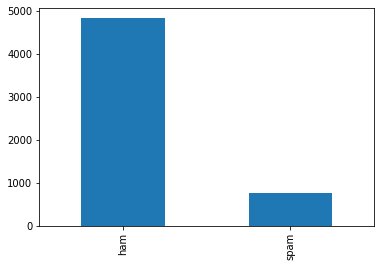

In [18]:
data.label.value_counts().plot.bar()

In [19]:
#Add numerical label for spam
data['spam'] = data['label'].map( {'spam': 1, 'ham': 0} ).astype(int)
data.head(15)

,label,text,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
6,ham,Even my brother is not like to speak with me. ...,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1


In [20]:
#1.2 length of message
#Add feature: length of message
data['length'] = data['text'].apply(len)
data.head(10)

,label,text,spam,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1,148
6,ham,Even my brother is not like to speak with me. ...,0,77
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0,160
8,spam,WINNER!! As a valued network customer you have...,1,158
9,spam,Had your mobile 11 months or more? U R entitle...,1,154


(-40, 950)

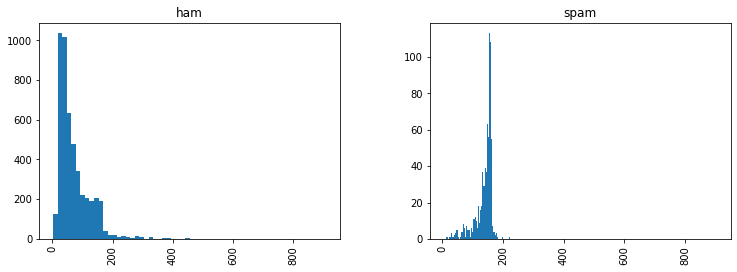

In [15]:
data.hist(column='length',by='label',bins=60,figsize=(12,4))
plt.xlim(-40,950)

In [21]:
data_ham  = data[data['spam'] == 0].copy()
data_spam = data[data['spam'] == 1].copy()

1.3 WordClouds

In [21]:
pip install wordcloud

In [22]:
import wordcloud

In [23]:
def show_wordcloud(data_spam_or_ham, title):
    text = ' '.join(data_spam_or_ham['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

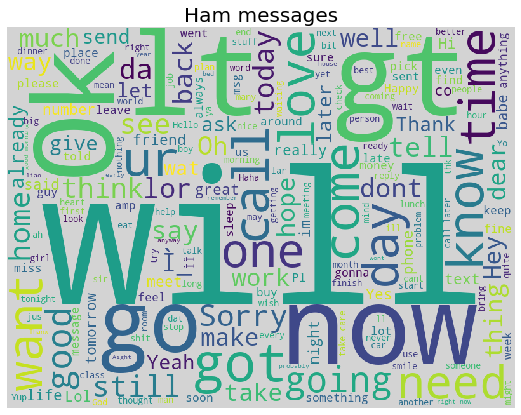

In [24]:
#WordCloud: Ham messages
show_wordcloud(data_ham, "Ham messages")

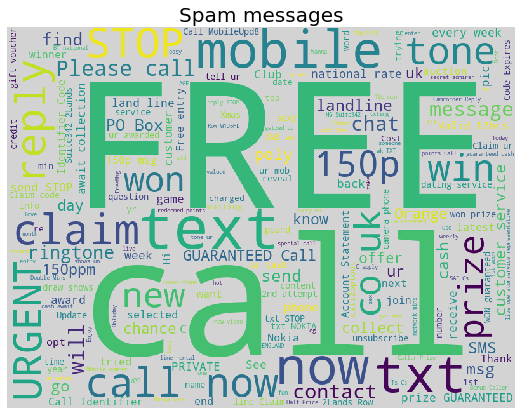

In [25]:
show_wordcloud(data_spam, "Spam messages")

# Part 2: Preprocessing

Basic preprocessing for common NLP tasks includes converting text to lowercase and removing punctuation and stopwords.
Further steps, especially for text classification tasks, are:

Tokenization
Vectorization and
TF-IDF weighting
Lets apply these approaches on the SMS messages.

#### 2.1 Remove Punctuation and Stopwords

In [26]:
#We use the punctuation list from the string library:
import string
#stopwords
from nltk.corpus import stopwords

In [27]:
#With the above lists for punctuation characters and stop words, 
#we define a function to remove these from the text, This function also converts all text to 
#lowercase
def remove_punctuation_and_stopwords(sms):
    
    sms_no_punctuation = [ch for ch in sms if ch not in string.punctuation]
    sms_no_punctuation = "".join(sms_no_punctuation).split()
    
    sms_no_punctuation_no_stopwords = \
        [word.lower() for word in sms_no_punctuation if word.lower() not in stopwords.words("english")]
        
    return sms_no_punctuation_no_stopwords

In [28]:
data['text'].apply(remove_punctuation_and_stopwords).head()

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, goes, usf, lives, around, t...
Name: text, dtype: object

#### 2.2 Top 30 words in ham and spam messages

In [ ]:
#### 2.2.1 Collections: Counter

In [29]:
from collections import Counter

In [30]:
data_ham.loc[:, 'text'] = data_ham['text'].apply(remove_punctuation_and_stopwords)
words_data_ham = data_ham['text'].tolist()
data_spam.loc[:, 'text'] = data_spam['text'].apply(remove_punctuation_and_stopwords)
words_data_spam = data_spam['text'].tolist()

In [35]:
list_ham_words = []
for sublist in words_data_ham:
    for item in sublist:
        list_ham_words.append(item)

In [37]:
list_spam_words = []
for sublist in words_data_spam:
    for item in sublist:
        list_spam_words.append(item)

In [38]:
c_ham  = Counter(list_ham_words)
c_spam = Counter(list_spam_words)
df_hamwords_top30  = pd.DataFrame(c_ham.most_common(30),  columns=['word', 'count'])
df_spamwords_top30 = pd.DataFrame(c_spam.most_common(30), columns=['word', 'count'])

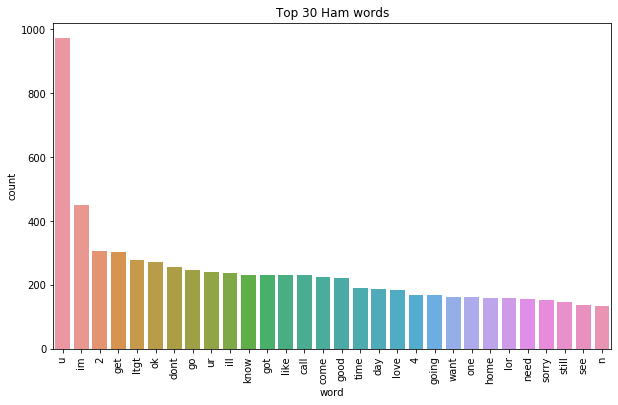

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_hamwords_top30, ax=ax)
plt.title("Top 30 Ham words")
plt.xticks(rotation='vertical');

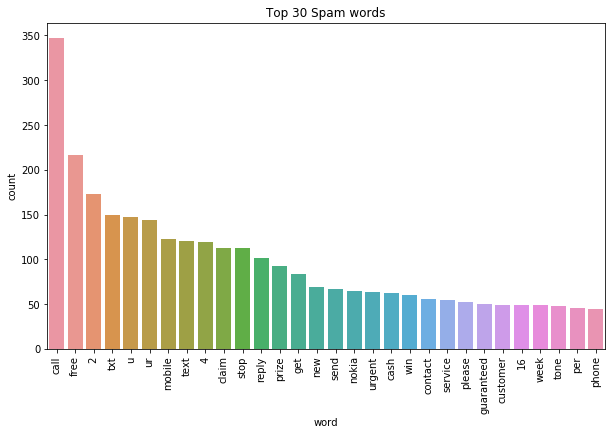

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_spamwords_top30, ax=ax)
plt.title("Top 30 Spam words")
plt.xticks(rotation='vertical');

#### 2.2.2 NLTK: FreqDist

In [41]:
fdist_ham  = nltk.FreqDist(list_ham_words)
fdist_spam = nltk.FreqDist(list_spam_words)

In [42]:
df_hamwords_top30_nltk  = pd.DataFrame(fdist_ham.most_common(30),  columns=['word', 'count'])
df_spamwords_top30_nltk = pd.DataFrame(fdist_spam.most_common(30), columns=['word', 'count'])

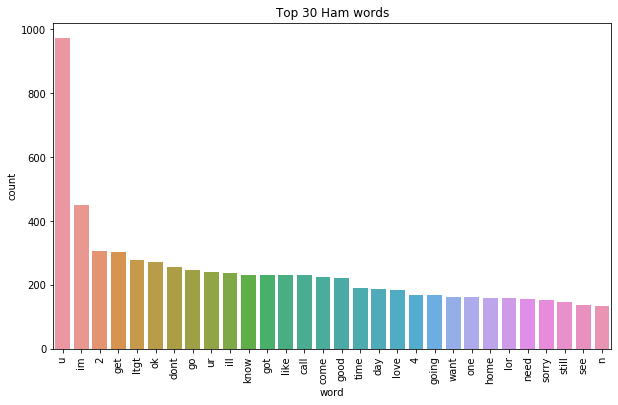

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_hamwords_top30_nltk, ax=ax)
plt.title("Top 30 Ham words")
plt.xticks(rotation='vertical');

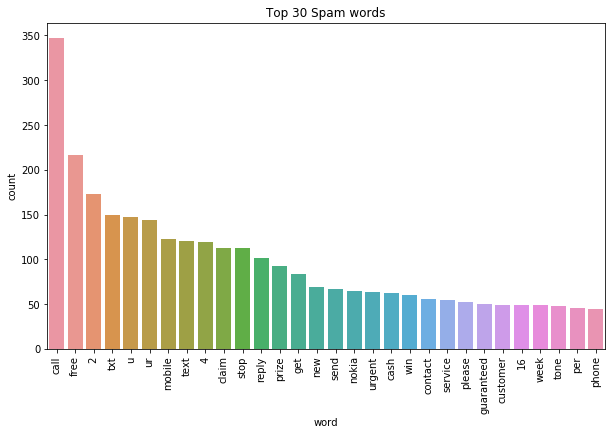

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_spamwords_top30_nltk, ax=ax)
plt.title("Top 30 Spam words")
plt.xticks(rotation='vertical');

#### 2.2 Bag of words with CountVectorizer

The Bag of Words representation
https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length.
In order to address this, scikit-learn provides utilities for the most common ways to extract numerical features from text content, namely:

Tokenization
tokenizing strings and giving an integer id for each possible token, for instance by using white-spaces and punctuation as token separators.
Vectorization
counting the occurrences of tokens in each document.
TF-IDF
normalizing and weighting with diminishing importance tokens that occur in the majority of samples / documents.

Bag of Words
In this scheme, features and samples are defined as follows: each individual token occurrence frequency (normalized or not) is treated as a feature.
the vector of all the token frequencies for a given document is considered a multivariate sample.
A corpus of documents can thus be represented by a matrix with one row per document and one column per token (e.g. word) occurring in the corpus.
We call vectorization the general process of turning a collection of text documents into numerical feature vectors.
This specific strategy (tokenization, counting and normalization) is called the Bag of Words or “Bag of n-grams” representation.
Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

For futher details and example implementations see:
https://en.wikipedia.org/wiki/Bag-of-words_model
https://en.wikipedia.org/wiki/Document-term_matrix

An Introduction to Bag-of-Words in NLP
https://medium.com/greyatom/an-introduction-to-bag-of-words-in-nlp-ac967d43b428

In this kernel we apply the CountVectorizer from sklearn as BOW model.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
As tokenizer we use the remove_punctuation_and_stopwords function defined above

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(analyzer = remove_punctuation_and_stopwords).fit(data['text'])

In [46]:
print(len(bow_transformer.vocabulary_))
#In all sms messages bow_transformer counted 9431 different words.

9431


In [47]:
#Examples for spam and ham messages
sample_spam = data['text'][8]
bow_sample_spam = bow_transformer.transform([sample_spam])
print(sample_spam)
print(bow_sample_spam)

WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
  (0, 218)	1
  (0, 323)	1
  (0, 1906)	1
  (0, 2184)	2
  (0, 2245)	1
  (0, 2531)	1
  (0, 4194)	1
  (0, 4759)	1
  (0, 5707)	1
  (0, 6538)	1
  (0, 6775)	1
  (0, 6946)	1
  (0, 7209)	1
  (0, 8694)	1
  (0, 8698)	1
  (0, 9028)	1
  (0, 9418)	1


In [48]:
#Applying bow_transformer on all messages
bow_data = bow_transformer.transform(data['text'])

In [49]:
bow_data.shape

(5572, 9431)

In [50]:
bow_data.nnz

49772

In [51]:
#Sparsity: percentage of none zero entries
print( bow_data.nnz / (bow_data.shape[0] * bow_data.shape[1]) *100 )

0.09471444959776236


### 2.3 Term frequency inverse document frequency - TFIDF
From occurrences to frequencies
https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#from-occurrences-to-frequencies

Occurrence count is a good start but there is an issue: longer documents will have higher average count values
than shorter documents, even though they might talk about the same topics.
To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document
by the total number of words in the document: these new features are called tf for Term Frequencies.
Another refinement on top of tf is to downscale weights for words that occur in many documents in the corpus and are
therefore less informative than those that occur only in a smaller portion of the corpus.
This downscaling is called tf–idf for “Term Frequency times Inverse Document Frequency”.

For futher details and example implementations see:
https://en.wikipedia.org/wiki/Tf%E2%80%93idf

https://www.kaggle.com/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments

TfidfTransformer from sklearn
Both tf and tf–idf can be computed as follows using TfidfTransformer:
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

In [52]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(bow_data)

In [54]:
data_tfidf = tfidf_transformer.transform(bow_data)

In [55]:
np.shape(data_tfidf)

(5572, 9431)